# Решающие деревья. Случайный лес

## Введение

### Простое определение

**Дерево принятия решений (decision tree)** - алгоритм машинного обучения, предсказывает целевую переменную с помощью применения последовательности простых решающих правил (предикатов).


### Наглядный пример

![](https://i.kym-cdn.com/entries/icons/original/000/006/117/81939832_3194411770585244_1699876574616092672_n.png)

### Менее наглядный пример

![](https://yastatic.net/s3/ml-handbook/admin/3_2_41c1793bef.png)

### Более строгое определение

**Решающее дерево** - бинарное дерево, в котором:
1. каждой внутренней вершине $v$ приписан предикат $B_v: \mathbb{X} \to \{0,1\}$
2. каждой листовой вершине $v$ приписан прогноз $c_v \in \mathbb{Y}$, где $\mathbb{Y}$ — область значений целевой переменной (в случае классификации листу может быть также приписан вектор вероятностей классов).

**Предсказание** - проход по этому дереву от корня к листу такой, что в каждой встречаемой внутренней вершине $v$ считаем значение $B_v(x)$: если $B_v(x)=1$, то идем вправо, если $B_v(x)=0$, то идем влево.

### Структура предиката

Вообще предикат $B_v(x)$ может иметь любую структуру, однако, на практике чаще всего используют сравнение j-го признака с некоторым пороговым значением:

$$B_v(x, j, t) = [x_j \leq t]$$

Из структуры предиката можем сделать следующие выводы:

1. выученная функция является кусочно-постоянной, из-за чего производная равна нулю везде, где задана $\to$ о градиентных методах при поиске оптимального решения можно забыть
2. дерево решений не сможет экстраполировать зависимости за границы области значений обучающей выборки
3. дерево решений способно идеально приблизить обучающую выборку и ничего не выучить (переобучиться): дерево с одним объектом в каждом листе $\to$ надо не просто приближать обучающую выборку как можно лучше, но и стремиться оставлять дерево как можно более простым.

### Пример переобучения

Переобученное дерево - не ограничивали глубину:

![](https://yastatic.net/s3/ml-handbook/admin/3_5_74f1de3be9.png)

Нормально обученное дерево - ограничили глубину значением 3:

![](https://yastatic.net/s3/ml-handbook/admin/3_4_aa20f33d21.png)

## Обучение дерева

Обучение с учителем, имеем датасет $(X, y)$:
- $X = \{x_i^{(1)}, \cdots, x_i^{(D)}\}_{i=1}^N, \quad x_i^{(j)} \in \mathbb{R} \quad \forall i, j $
- $y = \{y_i\}_{i=1}^N, \quad y_i \in \mathbb{R} \quad \forall i$

Пусть так же задана функция потерь $L(f, X, y)$.

Наша задача — построить решающее дерево $f$, наилучшим образом предсказывающее целевую зависимость - минимизируя $L$. Но градиенты использовать нельзя! Как быть?

### Решающие пни

Давайте начнём с простого — научимся строить решающие пни, то есть решающие деревья глубины $1$:

$$B_{j,t}(x) = [x_i^{(j)} \leq t]$$

Эту задачу можно решить полным перебором: существует не более $(N-1)D$ предикатов такого вида - $j$ пробегает значения от $1$ до $D$, а всего значений порога $t$, при которых меняется значение предиката, может быть не более $N-1$:

![](https://yastatic.net/s3/ml-handbook/admin/3_7_f51986c1ae.png)

Искомое решение - $(j_{opt}, t_{opt}) = \arg\min\limits_{j,t} L(B_{j,t}, X, y)$.

Для каждого из $B_{j,t}$ нужно посчитать значение функции потерь - это еще $N$ операций. Итоговая сложность - $O(N^2D)$

Сложность неприятная, но не заоблачная. Проблема в том, что мы посчитали оптимум только для одной вершины, а что если их больше?

Кроме того, при построении дерева нужно учесть склонность к переобучению, поэтому хотим построить **оптимальное по качеству** на обучающей выборке дерево **минимальной глубины**.

Такая задача является $NP$-полной - проще говоря, кроме как полным перебором ее не решить :(

Как быть в такой ситуации? Есть два выхода:

1. **Искать не оптимальное решение, а просто достаточно хорошее.**
    
    Строить дерево с помощью жадного алгоритма - не искать всю структуру сразу, а строить дерево "этаж за этажом". Тогда в каждой внутренней вершине дерева будет решаться задача, схожая с задачей построения решающего пня.
    
    Для того чтобы этот подход хоть как-то работал, его придётся прокачать внушительным набором эвристик.

2. **Оптимизировать алгоритм полного перебора** — наивную версию алгоритма (перебор наборов возможных предикатов и порогов) можно ускорить и асимптотически, и в константу раз.

### Жадный алгоритм построения решающего дерева

Пусть $X$ — исходное множество объектов обучающей выборки, а $X_m$ — множество объектов, попавших в текущий лист (в самом начале), тогда жадный алгоритм условно можно описать следующим образом:

1. Создаём вершину $v$
2. Если выполнен **критерий остановки** $Stop(X_m)$
, то останавливаемся, объявляем эту вершину листом и ставим ей в соответствие **ответ** $Ans(X_m)$, после чего возвращаем её.
    
    Иначе: находим предикат (иногда ещё говорят сплит) $B_{j,t}$, который определит наилучшее разбиение текущего множества объектов $X_m$ на две подвыборки $X_l$ и $X_r$, максимизируя **критерий ветвления** $Branch(X_m, j, t)$.
3. Для $X_l$ и $X_r$ рекурсивно повторим процедуру.

Данный алгоритм содержит в себе вспомогательные функции, которые нужно выбрать так, чтобы итоговое дерево хороошо минимизировало $L$:

- $Ans(X_m)$ - вычисляет ответ для листа по попавшим в него объектам из обучающей выборки:
    - классификация - метка самого частого класса
    - регрессия - среднее, медиана, другая статистика
    - простая модель - можем здесь поместить другую модель!
- Критерий остановки $Stop(X_m)$ - нужно ли продолжать ветвление:
    - обычно - тривиальное правило: глубина, кол-во объектов в $X_m$, степень однородности объектов
- Критерий ветвления $Branch(X_m, j, t)$ - измеряет, насколько хорошо предлагаемое разделение. Оценивает, насколько улучшится метрика качества по сравнению с не-ветвлением. С ее помощью их всех возможных сплитов выбираем тот, что дает наибольшее улучшение.

Остановимся на критериях ветвление подробнее.

## Критерии ветвления

Пусть $c$ - ответ дерева ($c \in \mathbb{R}$ для регрессии, $c \in \mathbb{N}$ или $c \in \mathbb{R}^K$ при $\sum_{i=1}^K c_i = 1$ для классификации), а $L(y_i, c)$ - заданная функция потерь.

Ищем оптимальный сплит $X_m  = X_l \cup X_r$. Если бы текущая вершина была листом, то ее ответ был бы $c$, тогда значение функции потерь:

$$\frac{1}{|X_m|} \sum_{(x_i,y_i) \in X_m} L(y_i, c)$$

Оптимальное значение этой величины:

$$H(X_m) = \min\limits_{c \in Y} \frac{1}{|X_m|}\sum_{(x_i,y_i) \in X_m} L(y_i, c)$$

называют **информативностью** (**impurity**). Чем она ниже, тем лучше объекты в листе можно приблизить константой.

Для решающего пня получим:

$$\frac{1}{|X^m|} \big( \sum_{(x_i,y_i) \in X_l} L(y_i, c_l) + \sum_{(x_i,y_i) \in X_r} L(y_i, c_r) \big)$$

Тогда разность информативностей исходной вершины и решающего пня:

$$H(X_m) - \frac{|X_l|}{|X_m|} H(X_l) - \frac{|X_r|}{|X_m|} H(X_r)$$

Для симметрии можем домножить на $|X_m|$:

$$Branch(X_m, j, t) = |X_m| \cdot H(X_m) - |X_l| \cdot H(X_l) - |X_r| \cdot H(X_r)$$

Эта величина неотрицательна - разделив объекты, хуже не сделаем. Чем она больше, тем лучше предлагаемое разделение.

Теперь рассмотрим, какие будут критерии ветвления для типичных задач:

### Регрессия - MSE

При MSE - $L(y_i,c ) = (y_i - c)^2$, тогда информативность:

$$H(X_m) = \min\limits_{c \in Y} \frac{1}{|X_m|}\sum_{(x_i,y_i) \in X_m} (y_i - c)^2$$

Оптимальное предсказание константного классификатора для MSE - среднее арифметическое $c = \frac{\sum y_i}{|X_m|}$:

$$H(X_m) = \sum_{(x_i,y_i) \in X_m} \frac{(y_i - \bar{y})^2}{|X_m|}$$

При жадной минимизации MSE информативность - оценка дисперсии целевых величин для объектов, попавших в лист.

Тогда выбирать сплиты нужно так, чтобы сумма дисперсий в листьях была как можно меньше.

### Регрессия - MAE

При MAE - $L(y_i,c ) = |y_i - c|$, оптимальное предсказание - медиана:

$$H(X_m) = \sum_{(x_i,y_i) \in X_m} \frac{|y_i - MEDIAN(y)|}{|X_m|}$$

### Классификация - Misclassification Error

Пусть в задаче $K$ классов, $p_k$ - доля объектов класса $k$ в текущей вершине:

$$p_k = \frac{1}{|X_m|} \sum_{(x_i, y_i) \in X_m} \mathbb{I}[y_i = k]$$

Нам интересна доля верно угаданных классов, функция потерь - $L(y_i, c) = \mathbb{I}[y_i \neq c]$.

Пусть предсказание модели в листе - один класс, тогда информативность:

$$H(X_m) = \min\limits_{c \in Y} \frac{1}{|X_m|}\sum_{(x_i,y_i) \in X_m} \mathbb{I}[y_i \neq c]$$

Оптимальное предсказание - самый частый класс $k_*$, информативность получится:

$$H(X_m) = \frac{1}{|X_m|}\sum_{(x_i,y_i) \in X_m} \mathbb{I}[y_i \neq k_*] = 1 - p_{k_*} = 1 - \max\limits_{k \in K} p_k$$

### Классификация - Энтропия

Предсказываем вероятностное распределение классов $(c_1, \cdots, c_K)$, можем подойти как к задаче логистической регрессии - через максимизацию логарифма правдоподобия. Пусть в вершине предсказывается фиксированное распределение $c$ (независящее от $x_i$), тогда правдоподобие:

$$ P(y|x, c) = P(y|c) = \prod_{(x_i,y_i) \in X_m} P(y_i|c) = \prod_{(x_i,y_i) \in X_m} \prod_{k=1}^K c_k^{\mathbb{I}[y_i=k]}, $$

прологарифмируем и получим:

$$ H(X_m) = \min\limits_{\sum_k c_k = 1} \big( -\frac{1}{|X_m|} \sum_{(x_i,y_i) \in X_m} \sum_{k=1}^K \mathbb{I}[y_i=k] \log c_k \big) $$

Оптимальная оценка вероятностей $c_k$ - это $p_k$, т.е. доля попавших в лист объектов этого класса - выводится через условный минимум (лагранжиан).


Подставим вектор $c=(p_1, \cdots, p_K)$:

$$H(X_m) = - \sum_{k=1}^K p_k \log p_k$$

### Классификация - Критерий Джини

>**Внимание!**
>
> Не путать с индексом Джини из экономики! Это разные вещи!

Предсказание - распределение вероятности $(c_1, \cdots, c_K)$. Вместо логарифма правдоподобия в качестве критерия можно использовать метрику (по сути - MSE по вероятностям).

Тогда информативность:

$$ H(X_m) = \min\limits_{\sum_k c_k = 1} \frac{1}{|X_m|} \sum_{(x_i,y_i) \in X_m} \sum_{k=1}^K (c_k - \mathbb{I}[y_i=k])^2 $$

Оптимальное занчение этой метрики - выборочные оценки частот классов $(p_1, \cdots, p_K)$, $p_i = \frac{1}{|X_m|} \sum_{i} \mathbb{I}[y_i = k]$. Подставим в выражение выше, упростим и получим:

$$H(X_m) = \sum_{k=1}^K p_k(1-p_k) = 1 - \sum_{k=1}^K p_k^2 $$

### Сравнение

![](https://habrastorage.org/r/w1560/files/a88/bc3/e18/a88bc3e185b246e088a4382e212e4473.png)

## Неоптимальность критериев

Несмотря на все наши телодвиждения выше, жадный алгоритм не всегда позволяет найти самое оптимальное решение.

Простейший пример - задача XOR:

![](https://yastatic.net/s3/ml-handbook/admin/3_10_08f8ee6402.png)

Вне зависимости от того, что вы оптимизируете, жадный алгоритм не даст оптимального решения задачи XOR.

Но этим примером проблемы не исчерпываются. Бывают ситуации, когда оптимальное с точки зрения выбранной метрики дерево вы получите с критерием ветвления, построенным по другой метрике (например, MSE-критерий для MAE-задачи или Джини для misclassification error).

## Особенности работы с данными

### Категориальные признаки

На первый взгляд - все отлично, $x^{(i)} \in C$, при разбиении будет $C_m = C_l \cup C_r$, предикат вида $[x^{(i)} \in C_r]$. Это очень логично и естественно, но количество сплитов - $2^{M-1} -1$, перебирать очень долго.


Намного лучше упорядочить значения $c_m$ и работать как с числами.

### Работа с пропусками

Одна из приятных особенностей деревьев — способность обрабатывать пропуски в данных. Разберёмся, что при этом происходит на этапе обучения и на этапе применения дерева.

Пусть у нас есть некоторый признак $x^{(i)}$, значение которого пропущено у некоторых объектов, $X_m$ - множество объектов, пришедших в рассматриваемую вершину, $V_m$ — подмножество $X_m$, состоящее из объектов с пропущенным значением $x^{(i)}$.

В момент выбора сплитов по этому признаку мы будем просто игнорировать объекты из $V_m$, а когда сплит выбран, мы отправим их в оба поддерева, присвоив им веса $\frac{|X_l|}{|X_m|}$ для левого и $\frac{|X_r|}{|X_m|}$ для правого поддеревьев.

На этапе предсказания, если в вершину, в которой сплит идет по пропущенному признаку, пришел объект с пропущенным значением в этом признаке, то отправляем его в каждую из веток, получаем предсказания, взвешиваем с весами $\frac{|X_l|}{|X_m|}$ для левого и $\frac{|X_r|}{|X_m|}$ для правого поддеревьев.

## Регуляризация деревьев

Деревья легко переобучаются, процесс ветвления нужно ограничивать.

Основные способы:

- ограничение по максимальной глубине дерева;
- ограничение на минимальное количество объектов в листе;
- ограничение на максимальное количество листьев в дереве;
- требование, чтобы функционал качества $Branch$ при делении текущей подвыборки на две улучшался не менее чем на $s$ процентов.

Делать это можно на разных этапах работы алгоритма:

- во время построения дерева - **pre-pruning** или **early stopping**
- построить дерево жадно без ограничений, а затем провести стрижку (**pruning**) - удалить некоторые вершины из дерева так, чтобы итоговое качество упало не сильно, но дерево начало подходить под условия регуляризации. При этом качество стоит измерять на отдельной, отложенной выборке.

## Практика

Попробуем создать дерево для задачи бинарной классификации своими руками.

Для начала рассмотрим игрушечный датасет с лишь одним признаком:

![](https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png)

В качестве критерия ветвления возьмем энтропию Шеннона:

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
import math

def entropy(arr):
    probs = [arr.count(cls) / len(arr) for cls in list(set(arr))]
    return sum([-prob * math.log(prob) for prob in probs])  # формально должен быть двоичный логарифм, но технически можно и натуральный

arr = [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]

entropy(arr)

0.6881388137135884

Предположим, что сделали разбиение по какому-либо объекту нашего датасета. Посмотрим энтропию левого и правого поддеревьев:

In [18]:
entropy(arr[:13])

0.666278442414676

In [19]:
entropy(arr[13:])

0.410116318288409

![](https://habrastorage.org/r/w1560/storage2/785/21c/7c6/78521c7c61114d0c433d76cb4f282f15.png)

Попробуем найти самое оптимальное разбиение:

In [20]:
s0 = entropy(arr)

ids = []
igs = []
for i in range(1, len(arr)):
    print('split by x<=', i)
    arr1 = arr[:i]
    arr2 = arr[i:]

    s1 = entropy(arr1)
    s2 = entropy(arr2)
    print(f'entropies: {s1} \t {s2}')

    ig = s0 - len(arr1)/len(arr) * s1 - len(arr2)/len(arr) * s2
    print(f'ig: {ig}')
    ids.append(i)
    igs.append(ig)
    print('---------------------')

split by x<= 1
entropies: 0.0 	 0.6917614988524178
ig: 0.0309653898037916
---------------------
split by x<= 2
entropies: 0.6931471805599453 	 0.6869615765973234
ig: 0.0005586767200028708
---------------------
split by x<= 3
entropies: 0.6365141682948128 	 0.6774944044487072
ig: 0.01679144468796534
---------------------
split by x<= 4
entropies: 0.5623351446188083 	 0.6615632381579821
ig: 0.046421194263441046
---------------------
split by x<= 5
entropies: 0.5004024235381879 	 0.6365141682948128
ig: 0.08565258160793188
---------------------
split by x<= 6
entropies: 0.6365141682948128 	 0.6517565611726531
ig: 0.040954970404287416
---------------------
split by x<= 7
entropies: 0.6829081047004717 	 0.666278442414676
ig: 0.01603998949888391
---------------------
split by x<= 8
entropies: 0.6931471805599453 	 0.6791932659915256
ig: 0.003363981894694945
---------------------
split by x<= 9
entropies: 0.6869615765973234 	 0.6890092384766586
ig: 5.102308263066346e-05
---------------------
sp

In [21]:
max(igs)

0.11151711474310586

### Минимизация энтропии в отдельно взятом признаке

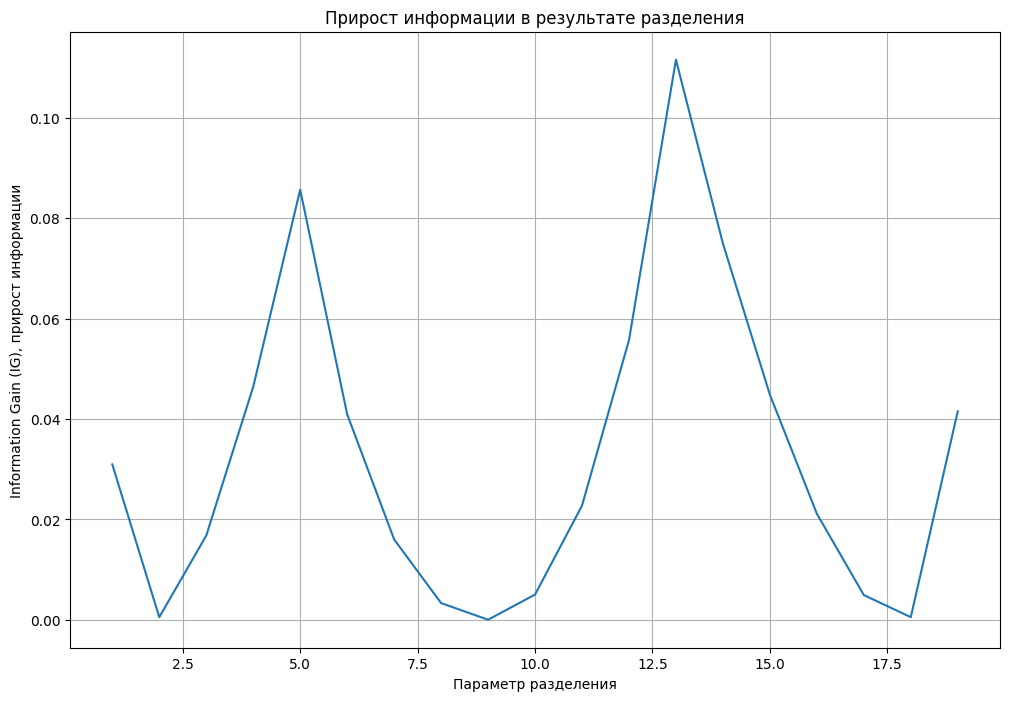

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(ids, igs)
ax.set_title('Прирост информации в результате разделения')
ax.set_ylabel('Information Gain (IG), прирост информации')
ax.set_xlabel(r'Параметр разделения')
ax.grid(True)
plt.show()

Теперь перейдем к целому дереву!

### Реализация целого дерева

Возьмем реальный датасет:

In [4]:
from sklearn import datasets
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
import pandas as pd

data = datasets.fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

In [5]:
df = pd.DataFrame(data.data, columns = data.feature_names)
df['price'] = data.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Наша модель дерева:

In [6]:
# на основе https://habr.com/ru/company/mailru/blog/438560/
from tqdm.auto import tqdm


class RegressionTree():
    '''
    Класс RegressionTree решает задачу регрессии. Основан на рекурсивных
    вызовах, когда прописываются условия выхода из рекурсии.
    '''
    def __init__(self, max_depth=3, min_size=8):
        self.left = None            # левый потомок
        self.right = None           # правый потомок
        self.max_depth = max_depth  # максимальная глубина
        self.min_size = min_size    # минимальный размер поддерева

        self.best_feat = None       # номер лучшего признака
        self.best_thresh = None     # значение лучшего признака

        self.value = 0              # значение в дереве
        self.error = 0.             # ошибка
        self.samples = 0            # кол-во объектов в обучающей выборке

    @staticmethod
    def _error(y):
        return np.mean((y - y.mean())**2)

    def fit(self, X, y):
        print('Start tree fit...')
        self.value = y.mean()
        self.error = self._error(y)
        self.samples = X.shape[0]

        # если дошли до глубины 0 - выходим
        if self.max_depth > 0:
            # начинаем цикл по признакам
            min_error = self.error
            for feat in tqdm(range(X.shape[1])):
                idxs = np.argsort(X[:, feat])  # сортируем признаки
                threshs = np.unique(X[:, feat])

                for thresh in threshs:
                    mask = X[:, feat] <= thresh
                    N1 = mask.sum()
                    N2 = self.samples - N1
                    if min(N1, N2) < self.min_size:
                        continue

                    S1, S2 = self._error(y[mask]), self._error(y[~mask])
                    error = N1/self.samples * S1 + N2/self.samples * S2
                    if error < min_error:
                        min_error = error
                        self.best_feat = feat
                        self.best_thresh = thresh

            print(f"x[{self.best_feat}] <= {self.best_thresh}")

        print(f"squared_error = {self.error}")
        print(f"samples = {self.samples}")
        print(f"value = {self.value}")
        print()

        # если не нашли лучший сплит, выходим
        if self.best_feat is None:
            return

        # дошли сюда - есть хорошее разбиение, нужно обучать дальше
        # инициализируем потомков - те же деревья решений
        self.left = RegressionTree(max_depth=self.max_depth-1, min_size=self.min_size)
        self.right = RegressionTree(max_depth=self.max_depth-1, min_size=self.min_size)

        # # обучаем
        mask = X[:, self.best_feat] < self.best_thresh
        self.left.fit(X[mask], y[mask])
        self.right.fit(X[~mask], y[~mask])

    def _predict_single(self, x):
        if self.best_feat is None:
            return self.value
        return self.left._predict_single(x) if x[self.best_feat] <= self.best_thresh else self.right._predict_single(x)

    def predict(self, X):
        y = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            y[i] = self._predict_single(X[i])

        return y

In [7]:
%%time
our_model = RegressionTree(max_depth=2) # это наш алгоритм
our_model.fit(X_train, y_train)

Start tree fit...


  0%|          | 0/8 [00:00<?, ?it/s]

x[0] <= 5.0447
squared_error = 1.3212269491017308
samples = 16512
value = 2.0665900841812017

Start tree fit...


  0%|          | 0/8 [00:00<?, ?it/s]

x[0] <= 3.1076
squared_error = 0.8291722661488075
samples = 12984
value = 1.7327727680221814

Start tree fit...
squared_error = 0.5632062436270177
samples = 6461
value = 1.3657477696950937

Start tree fit...
squared_error = 0.8270245695839482
samples = 6523
value = 2.096309256477081

Start tree fit...


  0%|          | 0/8 [00:00<?, ?it/s]

x[0] <= 6.992
squared_error = 1.212707641772731
samples = 3528
value = 3.2951286422902495

Start tree fit...
squared_error = 0.9017678449993043
samples = 2571
value = 2.930612816024893

Start tree fit...
squared_error = 0.7321032355947987
samples = 957
value = 4.274407836990595

CPU times: user 37.2 s, sys: 93 ms, total: 37.3 s
Wall time: 37.6 s


In [8]:
from sklearn.metrics import r2_score
preds = our_model.predict(X_test)
r2_score(y_test, preds)

0.4410829267527976

Сравним с `sklearn`:

In [9]:
%%time
model = tree.DecisionTreeRegressor(max_depth=2)
model.fit(X_train, y_train)

CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 33.4 ms


DecisionTreeRegressor(max_depth=2)

In [10]:
from sklearn.metrics import r2_score

r2_score(y_test, model.predict(X_test))

0.44108944061620625

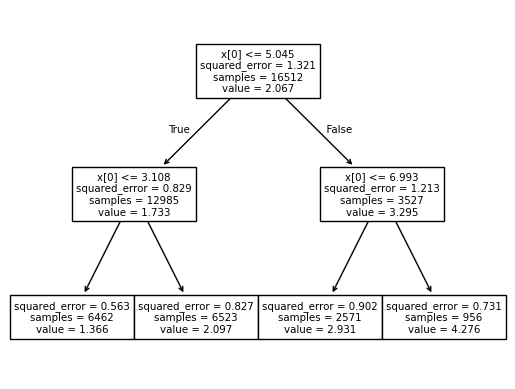

In [23]:
tree.plot_tree(model)
plt.show()

Совпало, но медленно :(

Качество не очень - поперебираем гиперпараметры:

In [24]:
from sklearn.model_selection import GridSearchCV

# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, len(X_train[0])-1]}

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(tree.DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1, scoring='r2', verbose=2)
gs.fit(X_train, y_train)

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 208 candidates, totalling 1040 fits


({'max_depth': 9, 'max_features': 7, 'min_samples_split': 7},
 np.float64(0.6946707160918733))

In [25]:
# по умолчанию grid search refit-ит лучшую модель для predict
r2_score(y_test, gs.predict(X_test))

0.7002083642560548

# Ансамбли

**Ансамблевые методы** - парадигма машинного обучения, в которой несколько моделей обучаются для решения одной и той же проблемы и объединяются для получения лучших результатов. Основная гипотеза - при правильном сочетании слабых моделей мы можем получить более точные и/или надежные модели.

Вводится понятие **_слабых учеников_** (или **_базовых моделей_**). Часто базовые модели работают сами по себе не так хорошо в связи с тем, для этого есть две причины:
- имеют высокое смещение - например, модели с низкой степенью свободы
- имеют слишком большой разброс, чтобы быть устойчивыми (например, модели с высокой степенью свободы).

**Идея ансамблевых методов** - попытаться уменьшить смещение и/или разброс таких слабых учеников, объединяя несколько из них вместе, чтобы создать **_сильного ученика_** (или **_модель ансамбля_**), который достигает лучших результатов.

## Математическое обоснование

Пусть решаем задачу регрессии и обучаем $n$ моделей, каждая из которых имеет ошибку $\varepsilon_i$. Будем считать, что все ошибки распределены по нормальному закону с нулевым средним $\mathbb{E}[\varepsilon_i]=0$, дисперсией $\mathbb{E}[\varepsilon_i^2]=\nu$ и ковариацией $\mathbb{E}[\varepsilon_i \varepsilon_j]=c$. В таком случае средняя ошибка предсказания ансамбля будет равна:

$$ \mathbb{E}[(\frac{1}{n}\sum_i\varepsilon_i)^2] = \frac{1}{n^2} \mathbb{E}[\sum_i (\varepsilon_i^2 + \sum_{j \ne i}\varepsilon_i \varepsilon_j)] = \frac{1}{n} \nu + \frac{n-1}{n} c $$

Рассмотрим два крайных случая:
- $c = \nu$ - ошибки разных моделей идеально скоррелированы, получаем, что квадрат ошибки никак не изменился
- $c = 0$ - ошибки разных моделей полностью независимы, получаем линейное уменьшение ошибки с ростом количества моделей в ансамбле

Отсюда можно сделать следующие выводы:
1. ансамблирование моделей с одинаковыми ошибками не уменьшает ошибку ансамбля
2. чтобы получить значительное уменьшение ошибки мы должны ансамблировать модели, в которых предсказания, а следовательно и ошибки, сильно отличаются

Для получения моделей с нескоррелированными предсказаниями, используются следующие подходы:
- обучить модели на разных поднаборах данных
- обучить модели на разных поднаборах признаках
- обучить модели с разной начальной инициализацией параметров
- обучить разные типы моделей модели

Небольшое забегание вперед:
- **Bootstrap** - статистический метод, заключающийся в генерации выборок размера $B$ (так называемых бутстрэп-выборок) из исходного датасета размера $L$ путем случайного выбора элементов с повторениями в каждом из наблюдений $B$.
- **Бэггинг** (**bagging**, **bootstrap aggregation**) - один из основных методов ансамблирования. Основная идея - используем набор отдельных обучающих выборок $X^i$, полученных из исходной выборки $X$ с помощью бутстрапа, для обучения набора базовых моделей $b_i(x)=b(x, X^i)$, а затем создаем из них ансамбль $a(x)$:
$$a(x)=\frac{1}{k} \sum_{i=1}^k b_i(x)$$


# Случайный лес

**Случайный лес** - ансамбль алгоритмов, где базовым алгоритмом является решающее дерево.

## Алгоритм построения

1. Строим $k$ деревьев. Для построения $i$-го дерева:
	1. Сначала, как в обычном бэггинге, из обучающей выборки $X$ выбирается с возвращением случайная подвыборка $X_i$ того же размера, что и $X$.
    2. В процессе обучения каждого дерева **в каждой вершине** случайно выбираются $n < N$ признаков, где $N$ — полное число признаков (**метод случайных подпространств, Random Subspace Method RSM**), и среди них ищется оптимальное разбиение. Такой приём как раз позволяет управлять степенью скоррелированности базовых алгоритмов.
2. Чтобы получить предсказание ансамбля на тестовом объекте, усредняем отдельные ответы деревьев (для регрессии) или берём самый популярный класс (для классификации).
3. Profit. Мы построили **Random Forest (случайный лес)** – комбинацию бэггинга и метода случайных подпространств над решающими деревьями.

## Гиперпараметры

### Глубина деревьев

Т.к. бэггинг позволяет снизить разброс, но не смещение, то стоит отдавать предпочтения алгоритмам с низким смещением. Такими алгоритмами являются глубокие деревья, которые хорошо переобучаются и могут запомнить подвыборку подробно. Поэтому предсказание на тестовом объекте будет сильнее меняться в зависимости от обучающей подвыборки, зато в среднем будет близко к истине (высокая дисперсия, низкое смещение).

**Вывод:** используем глубокие деревья.


### Количество признаков для отдельного дерева

Ограничивая число признаков, которые используются в обучении одного дерева, мы также управляем качеством случайного леса:
- Больше признаков - больше корреляция между деревьями, меньше чувствуется эффект от ансамблирования
- Меньше признаков, тем слабее сами деревья.

**Практическая рекомендация** – брать корень из числа всех признаков для классификации и треть признаков для регрессии.

### Количество деревьев в случайном лесе

Увеличение числа элементарных алгоритмов в ансамбле не меняет смещения и уменьшает разброс. Т.к. число признаков и варианты подвыборок, на которых строятся деревья в случайном лесе, ограничены, уменьшать разброс до бесконечности не получится. Поэтому имеет смысл **построить график ошибки** от числа деревьев и ограничить размер леса в тот момент, когда ошибка перестанет значимо уменьшаться.

Вторым практическим ограничением на количество деревьев может быть **время работы ансамбля**. Однако есть положительное свойство случайного леса: случайный лес можно строить и применять **параллельно**, что сокращает время работы, если у нас есть несколько процессоров. Но процессоров, скорее всего, всё же сильно меньше числа деревьев, а сами деревья обычно глубокие. Поэтому на большом числе деревьев Random Forest может работать дольше желаемого и количество деревьев можно сократить, немного пожертвовав качеством.

## Преимущества

1. Одна из лучших "универсальных" моделей - вместе с наивным баейсом, логистической регрессией
2. Работает очень эффективно с пропущенными признаками - потому что на некоторых деревьях вообще не используется выпавших признак
3. Есть классные модификации:
	- Extremely Randomized Trees - при разбиении признак вообще рандомно берем и для него ищем threshold
	- Isolation Forest - алгоритм поиска аномалий, можем поставить эту задачу деревьям
4. Позволяет использовать тренировочный датасет для валидации - **Out Of Bag (OOB) estimation** (можно использовать и в обычном бэггинге) - обучение базовых моделей делается на подвыборке тестовой выборки, поэтому некоторые данные оттуда они не видели никогда.

# Практика

Данные:

https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes?select=bmw.csv

In [26]:
!gdown 1WTidqZeIKqZqcNsEheMYi9QyycRr5IPV

Downloading...
From: https://drive.google.com/uc?id=1WTidqZeIKqZqcNsEheMYi9QyycRr5IPV
To: /content/cars.zip
100% 1.15M/1.15M [00:00<00:00, 62.5MB/s]


In [27]:
!unzip -d cars cars.zip

Archive:  cars.zip
  inflating: cars/audi.csv           
  inflating: cars/bmw.csv            
  inflating: cars/cclass.csv         
  inflating: cars/focus.csv          
  inflating: cars/ford.csv           
  inflating: cars/hyundi.csv         
  inflating: cars/merc.csv           
  inflating: cars/skoda.csv          
  inflating: cars/toyota.csv         
  inflating: cars/unclean cclass.csv  
  inflating: cars/unclean focus.csv  
  inflating: cars/vauxhall.csv       
  inflating: cars/vw.csv             


In [28]:
from pathlib import Path

dfs = []
for path in Path('./cars').rglob('*.csv'):
    df = pd.read_csv(path)
    dfs.append(df)

df = pd.concat(dfs, axis=0)

In [29]:
df

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg,fuel type,engine size,mileage2,fuel type2,engine size2,reference,tax(£)
0,Focus,2016.0,8000,Manual,38852,Petrol,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Focus,2019.0,13400,Manual,11952,Petrol,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Focus,2019.0,14600,Manual,22142,Petrol,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Focus,2016.0,9450,Manual,14549,Diesel,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Focus,2015.0,9999,Manual,7010,Diesel,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,I30,2016.0,8680,Manual,25906,Diesel,1.6,NaN,78.4,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4856,I40,2015.0,7830,Manual,59508,Diesel,1.7,NaN,65.7,NaN,NaN,NaN,NaN,NaN,NaN,30.0
4857,I10,2017.0,6830,Manual,13810,Petrol,1.0,NaN,60.1,NaN,NaN,NaN,NaN,NaN,NaN,20.0
4858,Tucson,2018.0,13994,Manual,23313,Petrol,1.6,NaN,44.8,NaN,NaN,NaN,NaN,NaN,NaN,145.0


<Axes: >

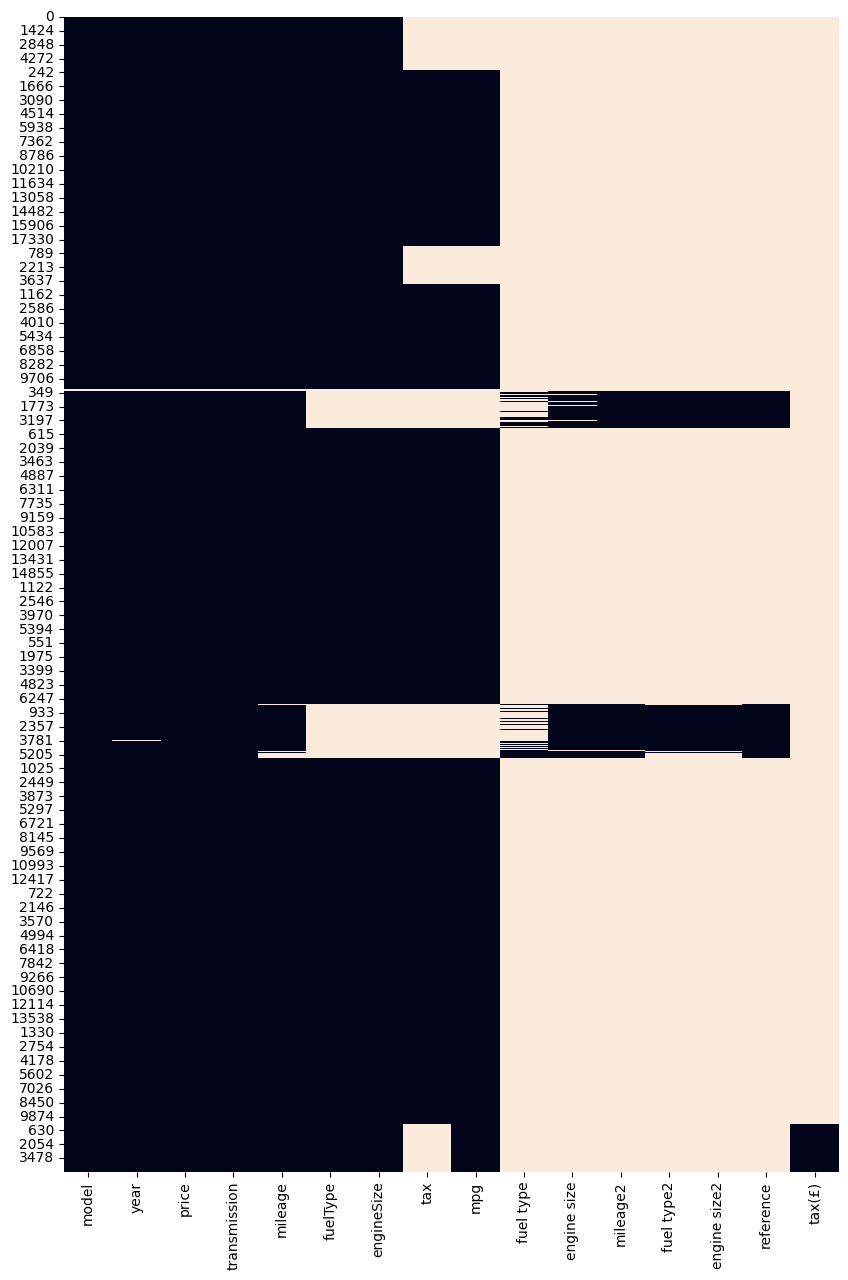

In [30]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize = (10, 15))
sns.heatmap(df.isnull(), cbar=False)

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
5454,Fiesta,2017.0,12000,Automatic,15944,Petrol,1.0,150.0,57.7
5455,Focus,2018.0,14000,Manual,9083,Petrol,1.0,150.0,57.7
5456,Focus,2017.0,13000,Manual,12456,Petrol,1.0,150.0,57.7
5457,Fiesta,2019.0,17500,Manual,10460,Petrol,1.5,145.0,40.3
5458,Fiesta,2019.0,16500,Automatic,1482,Petrol,1.0,145.0,48.7
...,...,...,...,...,...,...,...,...,...
113285,A3,2020.0,16999,Manual,4018,Petrol,1.0,145.0,49.6
113286,A3,2020.0,16999,Manual,1978,Petrol,1.0,150.0,49.6
113287,A3,2020.0,17199,Manual,609,Petrol,1.0,150.0,49.6
113288,Q3,2017.0,19499,Automatic,8646,Petrol,1.4,150.0,47.9


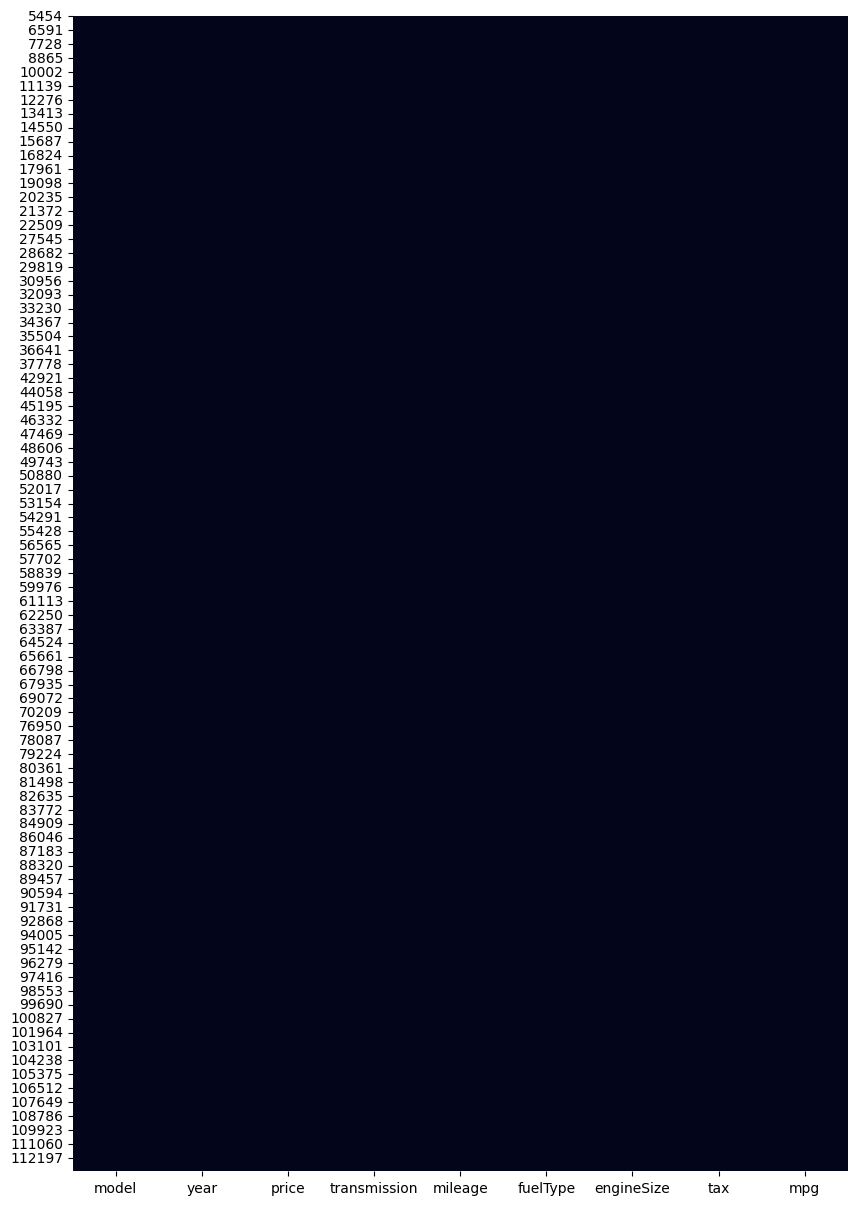

In [31]:
df.drop(columns=df.columns[9:], inplace=True)
df.reset_index(inplace=True, drop=True)
df.dropna(inplace=True)

figure(figsize = (10, 15))
sns.heatmap(df.isnull(), cbar=False)
df

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94327 entries, 5454 to 113289
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         94327 non-null  object 
 1   year          94327 non-null  float64
 2   price         94327 non-null  object 
 3   transmission  94327 non-null  object 
 4   mileage       94327 non-null  object 
 5   fuelType      94327 non-null  object 
 6   engineSize    94327 non-null  float64
 7   tax           94327 non-null  float64
 8   mpg           94327 non-null  float64
dtypes: float64(4), object(5)
memory usage: 9.2+ MB


In [33]:
df.describe()

,year,engineSize,tax,mpg
count,94327.000000,94327.000000,94327.000000,94327.000000
mean,2017.086698,1.673861,120.256183,55.235816
std,2.133897,0.562523,63.404805,16.291667
min,1970.000000,0.000000,0.000000,0.300000
25%,2016.000000,1.300000,125.000000,47.100000
50%,2017.000000,1.600000,145.000000,54.300000
75%,2019.000000,2.000000,145.000000,62.800000
max,2060.000000,6.600000,580.000000,470.800000


In [34]:
df

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
5454,Fiesta,2017.0,12000,Automatic,15944,Petrol,1.0,150.0,57.7
5455,Focus,2018.0,14000,Manual,9083,Petrol,1.0,150.0,57.7
5456,Focus,2017.0,13000,Manual,12456,Petrol,1.0,150.0,57.7
5457,Fiesta,2019.0,17500,Manual,10460,Petrol,1.5,145.0,40.3
5458,Fiesta,2019.0,16500,Automatic,1482,Petrol,1.0,145.0,48.7
...,...,...,...,...,...,...,...,...,...
113285,A3,2020.0,16999,Manual,4018,Petrol,1.0,145.0,49.6
113286,A3,2020.0,16999,Manual,1978,Petrol,1.0,150.0,49.6
113287,A3,2020.0,17199,Manual,609,Petrol,1.0,150.0,49.6
113288,Q3,2017.0,19499,Automatic,8646,Petrol,1.4,150.0,47.9


In [35]:
df.isnull().sum()

,0
model,0
year,0
price,0
transmission,0
mileage,0
fuelType,0
engineSize,0
tax,0
mpg,0


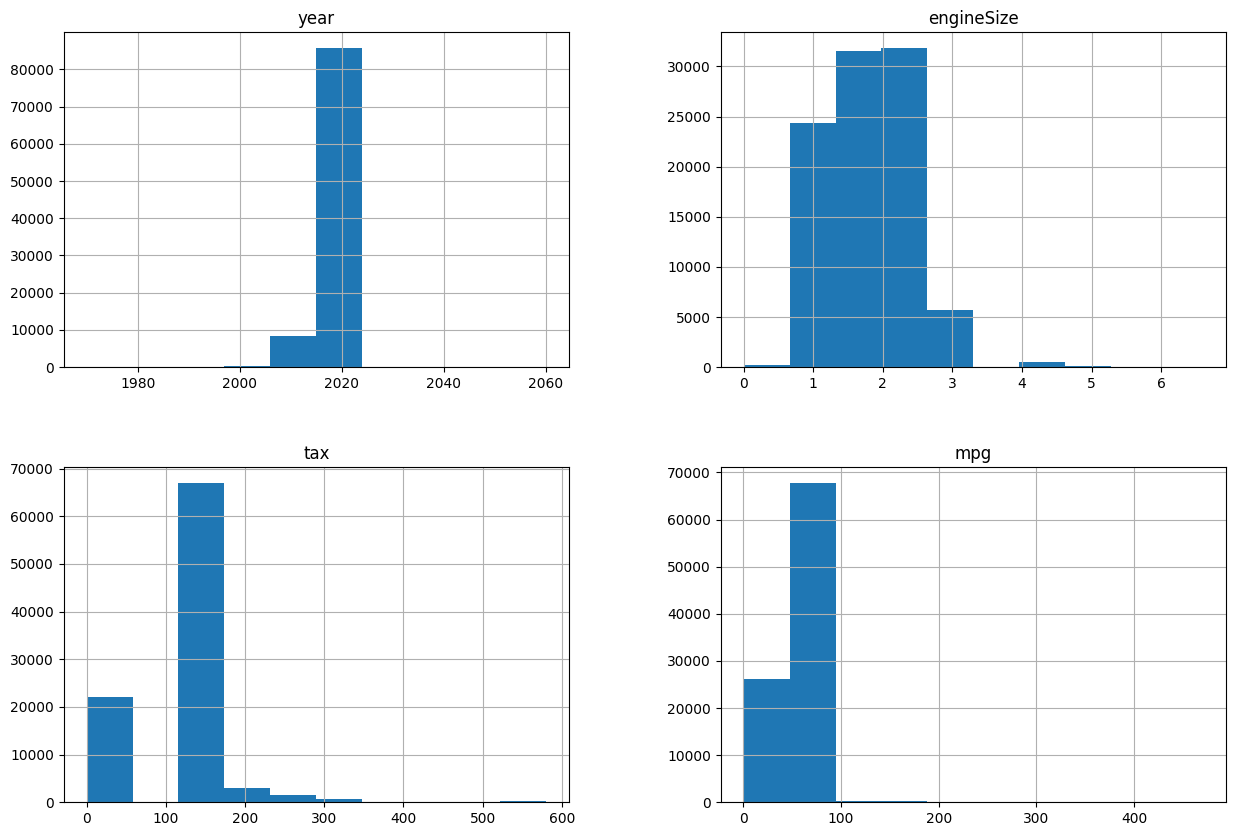

In [36]:
df.hist(figsize=(15, 10))
plt.show()

In [37]:
df['model'] = df['model'].apply(lambda x: x.strip())

In [38]:
df['model'].value_counts()

,count
model,
Fiesta,6557
Golf,4863
Focus,4588
C Class,3747
Corsa,3441
...,...
200,1
180,1
230,1


In [39]:
df.year.describe()

,year
count,94327.000000
mean,2017.086698
std,2.133897
min,1970.000000
25%,2016.000000
50%,2017.000000
75%,2019.000000
max,2060.000000


In [40]:
df[df['year'] >= 2021]

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
23180,Fiesta,2060.0,6495,Automatic,54807,Petrol,1.4,205.0,42.8


In [41]:
df = df[df['year'] < 2021]
df

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
5454,Fiesta,2017.0,12000,Automatic,15944,Petrol,1.0,150.0,57.7
5455,Focus,2018.0,14000,Manual,9083,Petrol,1.0,150.0,57.7
5456,Focus,2017.0,13000,Manual,12456,Petrol,1.0,150.0,57.7
5457,Fiesta,2019.0,17500,Manual,10460,Petrol,1.5,145.0,40.3
5458,Fiesta,2019.0,16500,Automatic,1482,Petrol,1.0,145.0,48.7
...,...,...,...,...,...,...,...,...,...
113285,A3,2020.0,16999,Manual,4018,Petrol,1.0,145.0,49.6
113286,A3,2020.0,16999,Manual,1978,Petrol,1.0,150.0,49.6
113287,A3,2020.0,17199,Manual,609,Petrol,1.0,150.0,49.6
113288,Q3,2017.0,19499,Automatic,8646,Petrol,1.4,150.0,47.9


In [42]:
df.price = df.price.astype(int)
df.mileage = df.mileage.astype(int)

<ipython-input-42-63d601d44e7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.price = df.price.astype(int)
<ipython-input-42-63d601d44e7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.mileage = df.mileage.astype(int)


In [43]:
df.describe()

,year,price,mileage,engineSize,tax,mpg
count,94326.000000,94326.000000,94326.000000,94326.000000,94326.000000,94326.000000
mean,2017.086243,17014.395670,23139.617030,1.673864,120.255285,55.235948
std,2.129329,9981.384529,21307.452346,0.562525,63.404540,16.291703
min,1970.000000,450.000000,1.000000,0.000000,0.000000,0.300000
25%,2016.000000,10199.000000,7368.000000,1.300000,125.000000,47.100000
50%,2017.000000,14599.000000,17460.000000,1.600000,145.000000,54.300000
75%,2019.000000,20998.000000,32456.000000,2.000000,145.000000,62.800000
max,2020.000000,159999.000000,323000.000000,6.600000,580.000000,470.800000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94326 entries, 5454 to 113289
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         94326 non-null  object 
 1   year          94326 non-null  float64
 2   price         94326 non-null  int64  
 3   transmission  94326 non-null  object 
 4   mileage       94326 non-null  int64  
 5   fuelType      94326 non-null  object 
 6   engineSize    94326 non-null  float64
 7   tax           94326 non-null  float64
 8   mpg           94326 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 9.2+ MB


## Кодировка

Рассмотрим 2 основных подхода к кодировке, выберем лучший по метрикам качества в алгоритмах:

In [45]:
from pandas.core.arrays import numeric

from sklearn.pipeline import Pipeline # конвер алгоритмов

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['price']),
    df['price'],
    test_size=0.33, random_state=42
)

In [47]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
numeric_features

['year', 'mileage', 'engineSize', 'tax', 'mpg']

In [48]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()
categorical_features

['model', 'transmission', 'fuelType']

In [49]:
# конвейер подготовки данных категориального типа
preprocessor = ColumnTransformer(
    [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
)

# подготовка и обучение алгоритма
alg = Pipeline(steps=[
    ('enc', preprocessor), # подготовка
    ('alg', RandomForestRegressor()) # алгоритм
])

In [50]:
# обучение алгоритма
alg.fit(X_train, y_train)

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'mileage',
                                                   'engineSize', 'tax',
                                                   'mpg']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['model', 'transmission',
                                                   'fuelType'])],
                                   verbose_feature_names_out=False)),
                ('alg', RandomForestRegressor())])

### Label encoder

In [51]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.select_dtypes(exclude='number').columns:
        print(column)
        encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
        result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

# используем все, кроме описания
encoded_data, encoders = number_encode_features(df) # Теперь encoded data содержит закодированные кат. признаки
encoded_data

model
transmission
fuelType


,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
5454,62,2017.0,12000,0,15944,4,1.0,150.0,57.7
5455,63,2018.0,14000,1,9083,4,1.0,150.0,57.7
5456,63,2017.0,13000,1,12456,4,1.0,150.0,57.7
5457,62,2019.0,17500,1,10460,4,1.5,145.0,40.3
5458,62,2019.0,16500,0,1482,4,1.0,145.0,48.7
...,...,...,...,...,...,...,...,...,...
113285,15,2020.0,16999,1,4018,4,1.0,145.0,49.6
113286,15,2020.0,16999,1,1978,4,1.0,150.0,49.6
113287,15,2020.0,17199,1,609,4,1.0,150.0,49.6
113288,111,2017.0,19499,0,8646,4,1.4,150.0,47.9


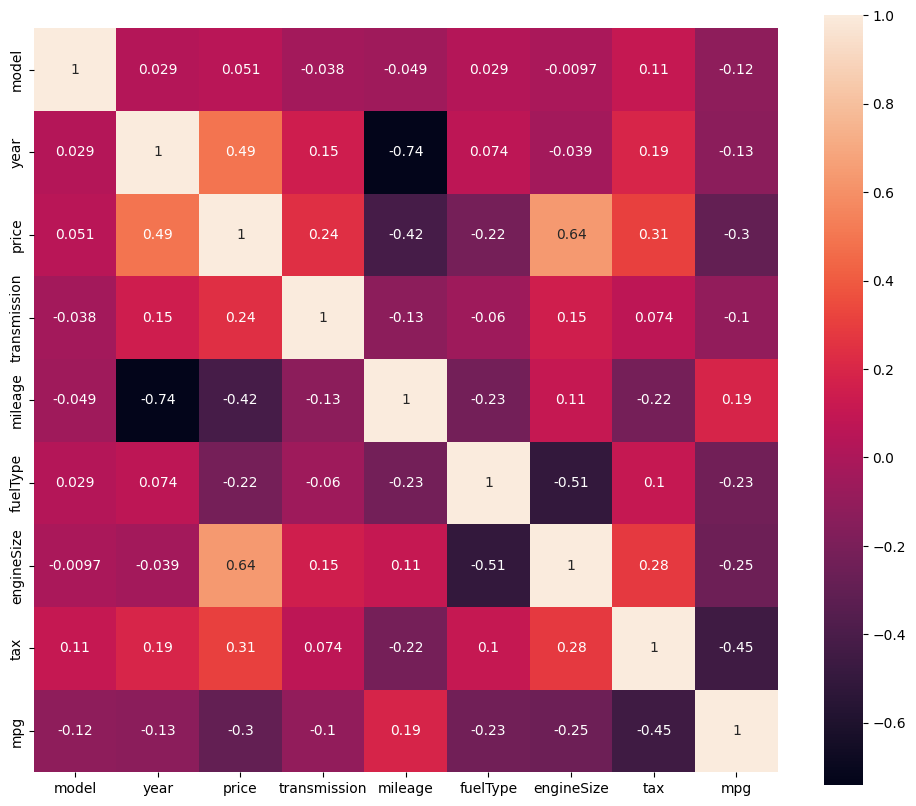

In [52]:
plt.subplots(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), square=True, annot=True)
plt.show()

Видим, что присутсвуют линейные корреляции, неплохой результат выдадут даже самые простые модели.

### One-hot

In [53]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'engineSize', 'tax', 'mpg'],
      dtype='object')

In [54]:
df.reset_index(inplace=True, drop=True)

In [55]:
df

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
0,Fiesta,2017.0,12000,Automatic,15944,Petrol,1.0,150.0,57.7
1,Focus,2018.0,14000,Manual,9083,Petrol,1.0,150.0,57.7
2,Focus,2017.0,13000,Manual,12456,Petrol,1.0,150.0,57.7
3,Fiesta,2019.0,17500,Manual,10460,Petrol,1.5,145.0,40.3
4,Fiesta,2019.0,16500,Automatic,1482,Petrol,1.0,145.0,48.7
...,...,...,...,...,...,...,...,...,...
94321,A3,2020.0,16999,Manual,4018,Petrol,1.0,145.0,49.6
94322,A3,2020.0,16999,Manual,1978,Petrol,1.0,150.0,49.6
94323,A3,2020.0,17199,Manual,609,Petrol,1.0,150.0,49.6
94324,Q3,2017.0,19499,Automatic,8646,Petrol,1.4,150.0,47.9


In [56]:
# data_onehot = pd.get_dummies(df, columns=['model', 'transmission','fuelType'])

from sklearn.preprocessing import OneHotEncoder
# выделяем в DataFrame категориальные колонки (тип - object)
# df.select_dtypes(include=[pd.categorical, pd.object])
categor = df[['model', 'transmission','fuelType', 'year']]

# в случае, если появляется неизвестных новых - игнорируем
enc = OneHotEncoder(handle_unknown='ignore')
# выбираем какие на основе каких признаков производить преобразования
enc.fit(categor)
# производим преобразования категориальных
codes = enc.transform(categor).toarray()
# выделим названия категориальных колонок из тех, на основе которых преобразуем
feature_names = enc.get_feature_names_out(categor.columns)
# объединяем числовые и категориальные колонки

data_onehot = pd.concat(
    [
        df[['price', 'mileage', 'tax', 'mpg', 'engineSize']], # исключаем категориальные = выбираем цифровые
        pd.DataFrame(codes,columns=feature_names)
    ],
    axis = 1
) # выбираем закодированные

In [57]:
enc.categories_

[array(['1 Series', '180', '2 Series', '200', '220', '230', '3 Series',
        '4 Series', '5 Series', '6 Series', '7 Series', '8 Series',
        'A Class', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Adam',
        'Agila', 'Amarok', 'Ampera', 'Antara', 'Arteon', 'Astra', 'Auris',
        'Avensis', 'Aygo', 'B Class', 'B-MAX', 'Beetle', 'C Class', 'C-HR',
        'C-MAX', 'CC', 'CL Class', 'CLA Class', 'CLC Class', 'CLK',
        'CLS Class', 'Caddy', 'Caddy Life', 'Caddy Maxi',
        'Caddy Maxi Life', 'California', 'Camry', 'Caravelle', 'Cascada',
        'Citigo', 'Combo Life', 'Corolla', 'Corsa', 'Crossland X',
        'E Class', 'EcoSport', 'Edge', 'Eos', 'Escort', 'Fabia', 'Fiesta',
        'Focus', 'Fox', 'Fusion', 'G Class', 'GL Class', 'GLA Class',
        'GLB Class', 'GLC Class', 'GLE Class', 'GLS Class', 'GT86', 'GTC',
        'Galaxy', 'Golf', 'Golf SV', 'Grand C-MAX',
        'Grand Tourneo Connect', 'Grandland X', 'Hilux', 'IQ', 'Insignia',
        'Jetta', 'KA

In [58]:
data_onehot

,price,mileage,tax,mpg,engineSize,model_1 Series,model_180,model_2 Series,model_200,model_220,...,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,year_2016.0,year_2017.0,year_2018.0,year_2019.0,year_2020.0
0,12000,15944,150.0,57.7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,14000,9083,150.0,57.7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,13000,12456,150.0,57.7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,17500,10460,145.0,40.3,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,16500,1482,145.0,48.7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94321,16999,4018,145.0,49.6,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94322,16999,1978,150.0,49.6,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94323,17199,609,150.0,49.6,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94324,19499,8646,150.0,47.9,1.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [59]:
data_onehot.isna().sum()

,0
price,0
mileage,0
tax,0
mpg,0
engineSize,0
...,...
year_2016.0,0
year_2017.0,0
year_2018.0,0
year_2019.0,0


In [60]:
df.shape

(94326, 9)

In [61]:
data_onehot.reset_index(inplace=True, drop=True)
data_onehot.shape

(94326, 219)

In [62]:
# названия признаков - запомним, понадобится при оценки важности признаков
one_hot_feature_names = data_onehot.columns.values
one_hot_feature_names

array(['price', 'mileage', 'tax', 'mpg', 'engineSize', 'model_1 Series',
       'model_180', 'model_2 Series', 'model_200', 'model_220',
       'model_230', 'model_3 Series', 'model_4 Series', 'model_5 Series',
       'model_6 Series', 'model_7 Series', 'model_8 Series',
       'model_A Class', 'model_A1', 'model_A2', 'model_A3', 'model_A4',
       'model_A5', 'model_A6', 'model_A7', 'model_A8', 'model_Adam',
       'model_Agila', 'model_Amarok', 'model_Ampera', 'model_Antara',
       'model_Arteon', 'model_Astra', 'model_Auris', 'model_Avensis',
       'model_Aygo', 'model_B Class', 'model_B-MAX', 'model_Beetle',
       'model_C Class', 'model_C-HR', 'model_C-MAX', 'model_CC',
       'model_CL Class', 'model_CLA Class', 'model_CLC Class',
       'model_CLK', 'model_CLS Class', 'model_Caddy', 'model_Caddy Life',
       'model_Caddy Maxi', 'model_Caddy Maxi Life', 'model_California',
       'model_Camry', 'model_Caravelle', 'model_Cascada', 'model_Citigo',
       'model_Combo Life', 'mo

### Train-test split

Разделим на треин-тест для обоих методов кодировки

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_onehot.drop(columns=['price']),
    data_onehot['price'],
    test_size=0.2
)

In [64]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    encoded_data.drop(['price'], axis=1),
    encoded_data['price'],
    test_size=0.2
)

## Алгоритмы

### Linear model

In [65]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train_, y_train_)

from sklearn import metrics
preds = regressor.predict(X_test_)

print(metrics.r2_score(y_test_, preds))

0.7096946429792876


In [66]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

from sklearn import metrics
preds = regressor.predict(X_test)

print(metrics.r2_score(y_test, preds))

0.8820908443945157


### Ridge

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [68]:
from sklearn.linear_model import Ridge, ElasticNet

ridge = Ridge(alpha=1)

ridge.fit(X_train_, y_train_)

metrics.r2_score(y_test_, ridge.predict(X_test_))

0.7096945436758963

In [69]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('ridge', Ridge())])

pipe.fit(X_train_, y_train_)

metrics.r2_score(y_test_, pipe.predict(X_test_))

0.7096945206866772

### SVM

In [70]:
from sklearn.svm import SVR

In [71]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('ridge', SVR())])

pipe.fit(X_train_, y_train_)

metrics.r2_score(y_test_, pipe.predict(X_test_))

0.29753786348947264

### Tree

In [72]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, X_train_.values.shape[0]-1]}

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1, scoring='r2', verbose=2)
gs.fit(X_train_.values, y_train_.values)

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 208 candidates, totalling 1040 fits


({'max_depth': 14, 'max_features': 75459, 'min_samples_split': 9},
 0.9287764018924605)

In [ ]:
gs.best_estimator_

DecisionTreeRegressor(max_depth=14, max_features=75459, min_samples_split=9)

In [ ]:
metrics.r2_score(y_test_, gs.predict(X_test_))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


0.9360348656915491

In [ ]:
gs.best_estimator_

DecisionTreeRegressor(max_depth=14, max_features=75459, min_samples_split=9)

In [ ]:
encoded_data.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'engineSize', 'tax', 'mpg'],
      dtype='object')

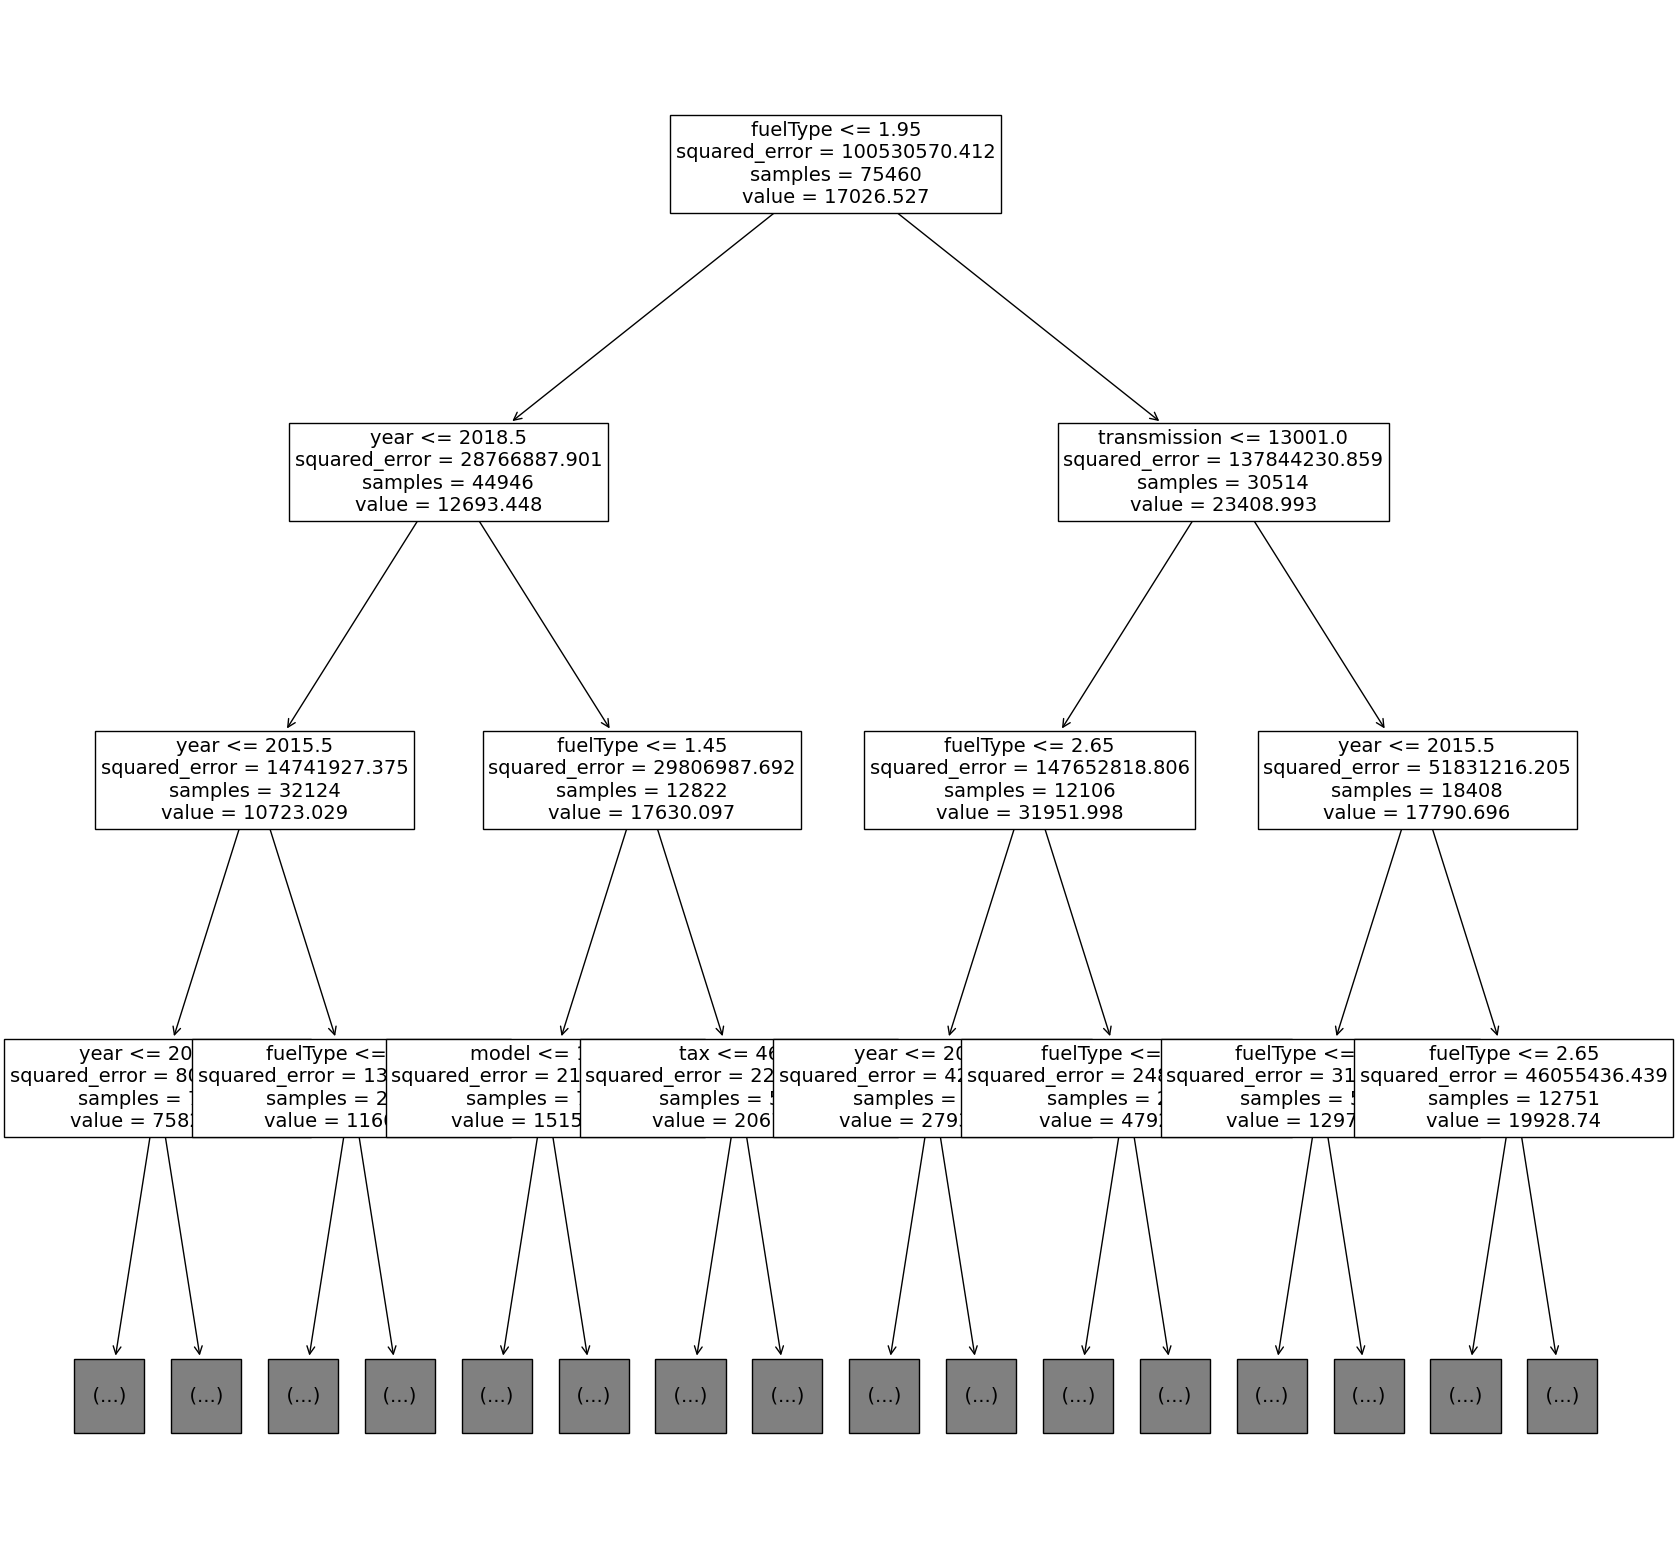

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(gs.best_estimator_, max_depth=3, fontsize=14, feature_names=encoded_data.columns)
plt.show()

### Decision Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()#criterion='entropy')
rf.fit(X_train_, y_train_)

metrics.r2_score(y_test_, rf.predict(X_test_))

0.9604278960023127

In [ ]:
metrics.mean_absolute_percentage_error(y_test_, rf.predict(X_test_))

0.07490724952712473

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 1.000e+00, 8.000e+00, 3.000e+00, 7.000e+00, 2.000e+01,
        4.400e+01, 7.000e+01, 1.650e+02, 4.220e+02, 1.491e+03, 6.412e+03,
        7.460e+03, 1.829e+03, 5.240e+02, 2.030e+02, 8.500e+01, 4.200e+01,
        2.100e+01, 1.200e+01, 9.000e+00, 7.000e+00, 4.000e+00, 6.000e+00,
        2.000e+00, 6.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-34153.27  , -32737.8584, -31322.4468, -29907.0352, -28491.6236,
        -27076.212 , -25660.8004, -24245.3888, -22829.9772, -21414.5656,
        -19999.154 , -18583.7424, -17168.3308, -15752.9192, -14337.5076,
        -12922.096 , -11506.6844, -10091.2728,  -8675.8612,  -7260.4496,
         -5845.038 ,  -4429.6264,  -3014.2148,  -1598.8032,   -183.3916,
          1

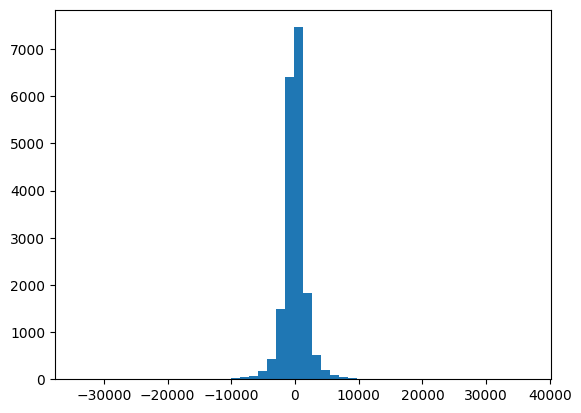

In [ ]:
plt.hist(y_test_ - rf.predict(X_test_), bins=50)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


rf = GradientBoostingRegressor(n_estimators=500)
rf.fit(X_train_, y_train_)

metrics.r2_score(y_test_, rf.predict(X_test_))

0.9416987851118258

In [ ]:
metrics.mean_absolute_percentage_error(y_test_, rf.predict(X_test_))

0.10170648511922427

In [ ]:
from sklearn.model_selection import GridSearchCV

# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {'max_depth': [i for i in range(2, 15)],}
            #   'min_samples_split': [i for i in range(2, 10)],
            #   'max_features': [2, X_train_.values.shape[0]-1]}

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1, scoring='r2', verbose=2)
gs.fit(X_train_.values, y_train_.values)

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 13 candidates, totalling 65 fits


KeyboardInterrupt: ignored

In [ ]:
from tqdm.auto import tqdm

In [ ]:
from time import sleep

for i in tqdm(range(1000)):
    sleep(2)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
metrics.r2_score(y_test_, gs.predict(X_test_))

0.9499657897890319

In [ ]:
from sklearn.preprocessing import scale, StandardScaler

In [ ]:
def plot_feature_importances(gs, column_names, top_n = 15):
    imp = pd.Series(gs.best_estimator_.feature_importances_, index = column_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 10))
    plt.title('Важность признаков по Giny Impurity')
    sns.barplot(x = imp.values[:top_n], y = imp.index.values[:top_n], orient='h')

In [ ]:
def plot_feature_importances(gs, column_names, top_n = 15):
    imp = pd.Series(gs.feature_importances_, index = column_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 10))
    plt.title('Важность признаков по MSE')
    sns.barplot(x = imp.values[:top_n], y = imp.index.values[:top_n], orient='h')

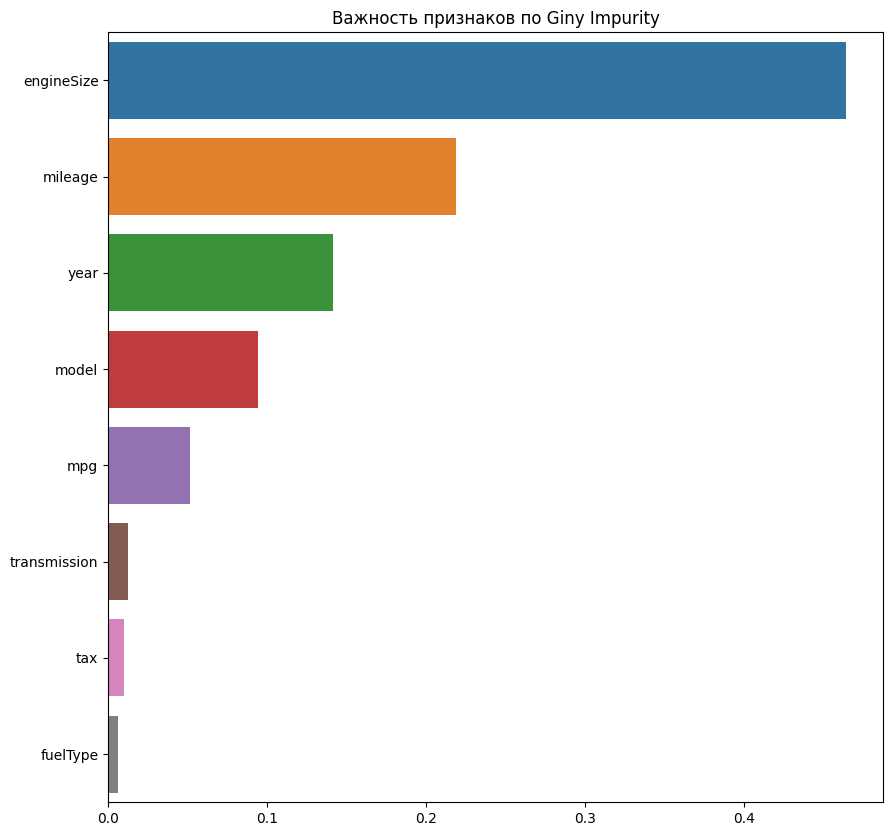

In [ ]:
plot_feature_importances(rf, encoded_data.drop(columns=['price']).columns)

In [ ]:
encoded_data.drop(columns=['price']).columns

Index(['model', 'year', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg',
       'engineSize'],
      dtype='object')